In [1]:
import graphviz
import pandas as pd
import sklearn as skl
import seaborn as sns
from sklearn import tree
from sklearn.cluster import KMeans 
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import .csv into dataframe
df = pd.read_csv('/Users/Shagz/Desktop/Think North Group/Database/Daily_Sales.csv')
df.head()

,City,DailyQuantity,Discount,Record ID,Item,Month,Promotion
0,Chicago,99,0.00,a061U000003sOQTQA2,Pennants,01 - Jan,None
1,Little Rock,206,0.10,a061U000003sOQUQA2,Backpacks,01 - Jan,Mail-in
2,New York City,225,0.15,a061U000003sOQVQA2,Gloves,01 - Jan,Contest
3,New Haven,104,0.10,a061U000003sOQWQA2,Hats,01 - Jan,Mail-in
4,Boston,557,0.10,a061U000003sOQXQA2,Hats,01 - Jan,Mail-in


### We won't need the Record ID. So we'll drop that column.

In [3]:
df.drop(['Record ID'], axis = 1, inplace = True)

In [4]:
df.head()

,City,DailyQuantity,Discount,Item,Month,Promotion
0,Chicago,99,0.00,Pennants,01 - Jan,None
1,Little Rock,206,0.10,Backpacks,01 - Jan,Mail-in
2,New York City,225,0.15,Gloves,01 - Jan,Contest
3,New Haven,104,0.10,Hats,01 - Jan,Mail-in
4,Boston,557,0.10,Hats,01 - Jan,Mail-in


### Let's understand what we're looking at better by seeing what unique values each categorical feature variable has. We'll save them as lists to use for plotting later.

In [81]:
cities = list(df.City.unique())
cities

['Chicago',
 'Little Rock',
 'New York City',
 'New Haven',
 'Boston',
 'San Francisco',
 'Miami',
 'Honolulu',
 'Dallas',
 'Detroit']

In [83]:
items = list(df.Item.unique())
items

['Pennants',
 'Backpacks',
 'Gloves',
 'Hats',
 'Jerseys',
 'Scarves',
 'Sweatshirt',
 'Sunglasses',
 'Polos']

In [84]:
promotions = list(df.Promotion.unique())
promotions

['None', 'Mail-in', 'Contest', 'Coupon', 'Display']

In [85]:
months = list(df.Month.unique())
months

['01 - Jan',
 '02 - Feb',
 '06 - Jun',
 '03 - Mar',
 '07 - Jul',
 '08 - Aug',
 '09 - Sep',
 '04 - Apr',
 '05 - May',
 '10 - Oct',
 '11 - Nov',
 '12 - Dec']

### Let's see how many of each there are.

In [9]:
df['Item'].value_counts()

Jerseys       3383
Sweatshirt    3377
Backpacks     3376
Polos         3372
Sunglasses    3371
Scarves       3368
Gloves        3361
Pennants      3358
Hats          3354
Name: Item, dtype: int64

In [10]:
df['Promotion'].value_counts()

Mail-in    17367
None        4434
Display     3091
Contest     3018
Coupon      2410
Name: Promotion, dtype: int64

In [11]:
df['Month'].value_counts()

01 - Jan    2783
03 - Mar    2516
04 - Apr    2515
05 - May    2514
06 - Jun    2513
07 - Jul    2512
08 - Aug    2511
09 - Sep    2510
10 - Oct    2509
11 - Nov    2508
12 - Dec    2507
02 - Feb    2422
Name: Month, dtype: int64

In [12]:
df['City'].value_counts()

New York City    3045
Miami            3043
New Haven        3041
Dallas           3041
San Francisco    3040
Chicago          3040
Honolulu         3038
Little Rock      3031
Detroit          3012
Boston           2989
Name: City, dtype: int64

### And a quick summary of the numerical data:

In [13]:
df.describe()

,DailyQuantity,Discount
count,30320.000000,30320.000000
mean,335.013555,0.098102
std,431.467426,0.062303
min,0.000000,0.000000
25%,81.000000,0.050000
50%,193.000000,0.100000
75%,418.000000,0.150000
max,5842.000000,0.200000


### Let's see how the main attributes are correlated to the daily quantity.

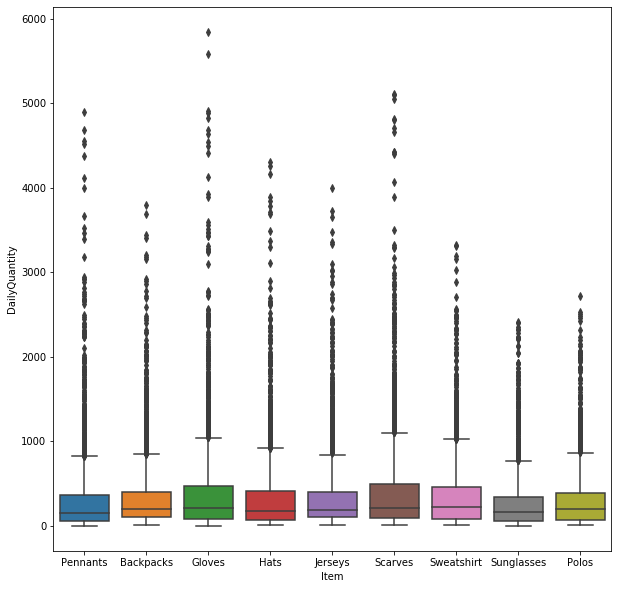

In [99]:
plt.figure(figsize = (10,10))
sns.boxplot(x = 'Item', y = 'DailyQuantity', data = df)

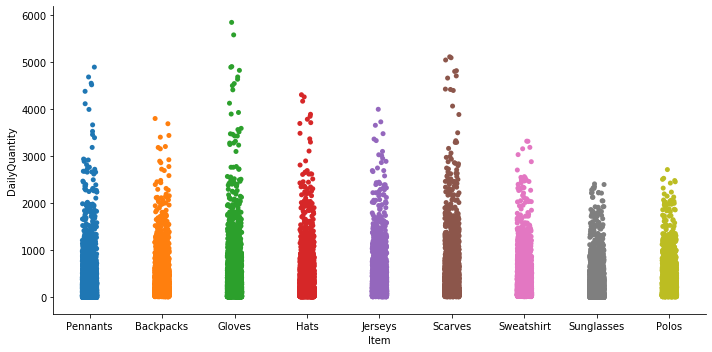

In [112]:
sns.catplot('Item', 'DailyQuantity', data = df, height=5, aspect=2)

### It seems that most products to similarly well on average, with a lot of overlap. So, the item won't be a good predictor variable.

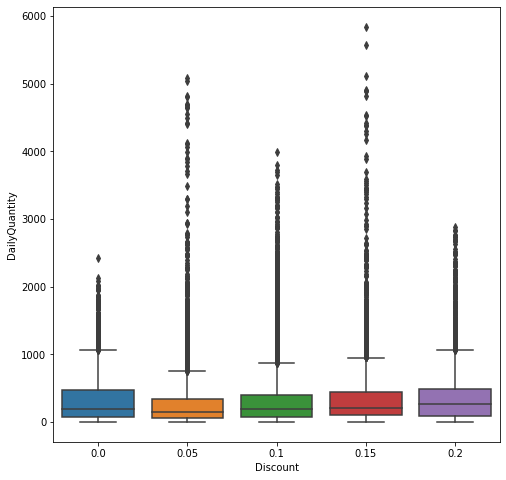

In [100]:
f, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(x = 'Discount', y = 'DailyQuantity', data = df)

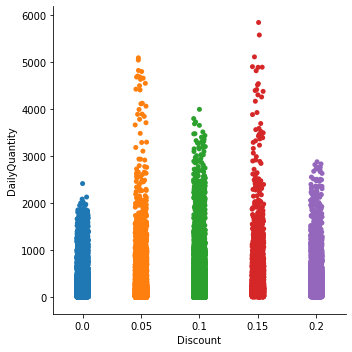

In [109]:
sns.catplot('Discount', 'DailyQuantity', data = df)
plt.show()

### Neither will the discount.

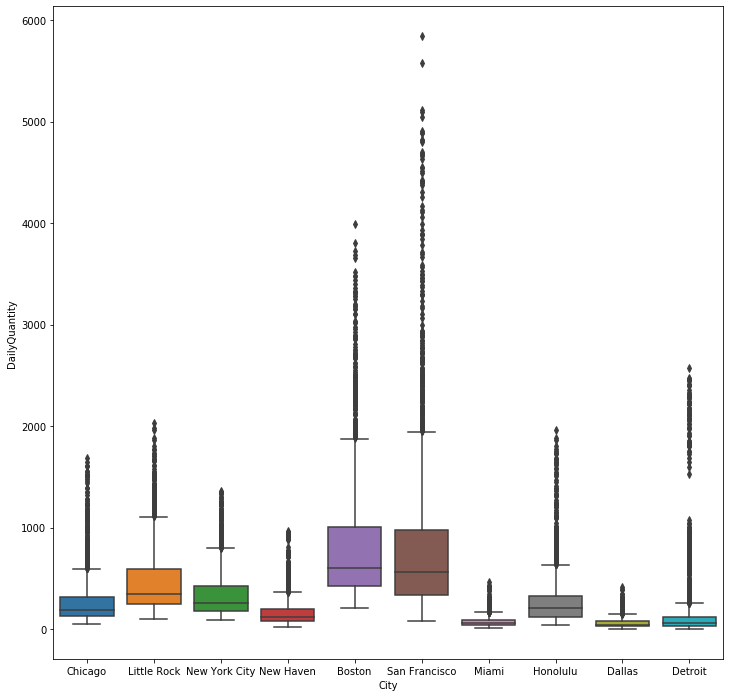

In [104]:
f, ax = plt.subplots(figsize = (12, 12))
sns.boxplot(x = 'City', y = 'DailyQuantity', data = df)

### These overlap less, so they're better predictor variables.

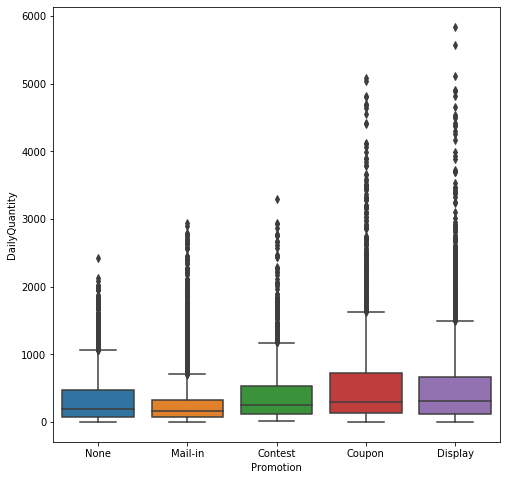

In [105]:
f, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(x = 'Promotion', y = 'DailyQuantity', data = df)

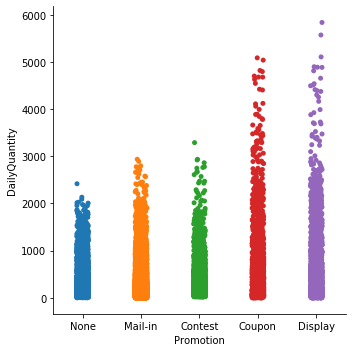

In [24]:
sns.catplot('Promotion', 'DailyQuantity', data = df)

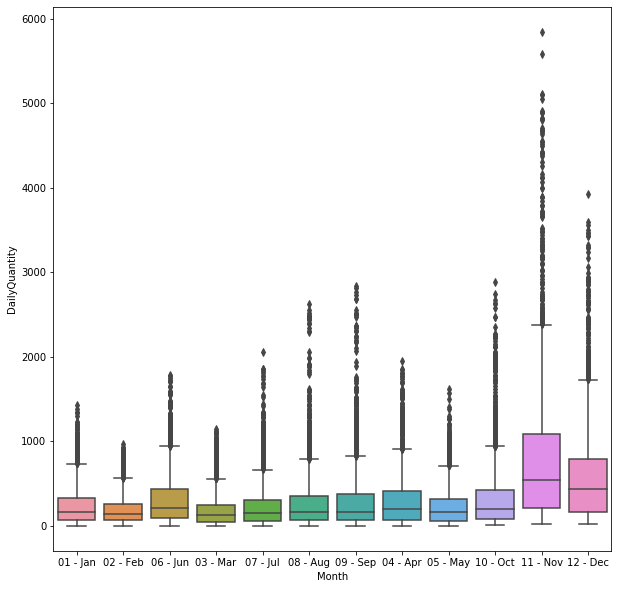

In [107]:
f, ax = plt.subplots(figsize = (10, 10))
sns.boxplot(x = 'Month', y = 'DailyQuantity', data = df)

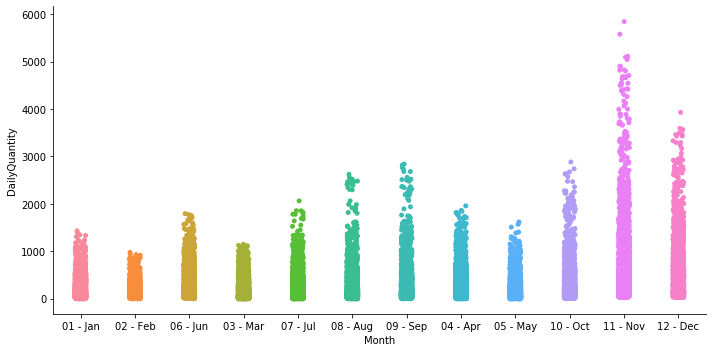

In [117]:
sns.catplot('Month', 'DailyQuantity', data = df, height = 5, aspect = 2)

### It seems that the best predictor variables are the City and the Month. Let's use a heatmap to see how these variables work together to determine the daily quantity.

In [19]:
# First we'll group the table.
df_group = df.groupby(['City', 'Month'], as_index = False).mean()
# We'll need to remove the Discount column
df_group.drop('Discount', axis = 1, inplace = True)
df_group

,City,Month,DailyQuantity
0,Boston,01 - Jan,600.863799
1,Boston,02 - Feb,448.910569
2,Boston,03 - Mar,500.210317
3,Boston,04 - Apr,760.750000
4,Boston,05 - May,551.048000
...,...,...,...
115,San Francisco,08 - Aug,670.738095
116,San Francisco,09 - Sep,829.591270
117,San Francisco,10 - Oct,830.444444
118,San Francisco,11 - Nov,1935.809524


In [20]:
# Now we'll use City as the index and pivot Month to become a row.
df_pivot = df_group.pivot(index = 'City', columns = 'Month')
df_pivot

DailyQuantity                                                  \
Month              01 - Jan    02 - Feb    03 - Mar    04 - Apr    05 - May   
City                                                                          
Boston           600.863799  448.910569  500.210317  760.750000  551.048000   
Chicago          186.541219  146.639004  141.583333  242.650794  162.896825   
Dallas            39.559140  101.677686   30.448413   57.035714   36.634921   
Detroit           51.360294   47.903766   28.221774   66.404858   39.375000   
Honolulu         201.620072  162.682008  144.539683  244.523810  188.623016   
Little Rock      323.207885  266.991736  250.511905  400.535714  373.825397   
Miami             54.451613   46.819672   40.428571   60.515873   59.357143   
New Haven        137.537634   94.008264  100.365079  158.059524  134.007937   
New York City    273.609319  195.272358  185.821429  278.206349  251.559524   
San Francisco    496.336918  420.867220  512.992063  770.384921  513.912698   

                                                                           \
Month            06 - Jun    07 - Jul    08 - Aug    09 - Sep    10 - Oct   
City                                                                        
Boston         686.427419  571.447154  685.377049  721.156379  829.074074   
Chicago        232.182540  211.111111  191.242063  188.369048  240.452381   
Dallas          54.246032   37.750000   40.369048   53.154762   56.515873   
Detroit        269.056225   51.676000   69.896414   62.571429   95.880952   
Honolulu       243.714286  199.440476  226.273810  235.857143  269.615079   
Little Rock    452.746032  353.003968  356.928571  449.203187  490.760000   
Miami           70.023810   58.353175   60.015873   62.797619   81.480159   
New Haven      149.507937  104.146825  141.373016  136.388889  167.103175   
New York City  298.448413  257.293651  301.507937  318.571429  318.753968   
San Francisco  702.849206  504.503968  670.738095  829.591270  830.444444   

                                         
Month             11 - Nov     12 - Dec  
City                                     
Boston         1781.641975  1441.798354  
Chicago         614.281746   495.210317  
Dallas          103.738095   100.535714  
Detroit         857.333333   188.039683  
Honolulu        664.511905   539.615079  
Little Rock     974.112450   806.354839  
Miami           150.297619   135.789683  
New Haven       311.607143   283.948413  
New York City   672.698413   619.535714  
San Francisco  1935.809524  1435.757937

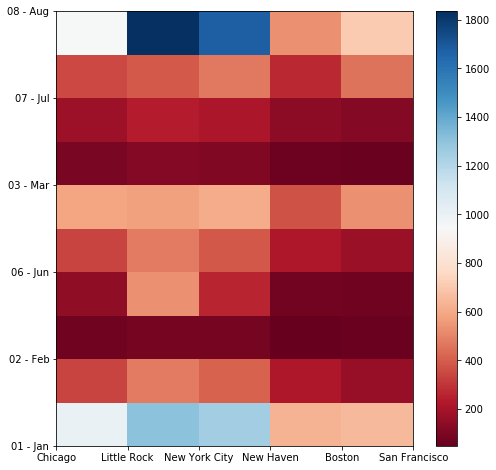

In [96]:
# Plot heatmap
f, ax = plt.subplots(figsize = (8, 8))
ax.set_xticklabels(cities)
ax.set_yticklabels(months)
plt.pcolor(df_pivot, cmap = 'RdBu')
plt.colorbar()
plt.show()

### We can see that the highest daily quantities occur in November and December, mostly at Boston and San Francisco and medium values at Little Rock and Detroit.

In [25]:
oneHot = pd.get_dummies(df)
oneHot.describe()

,DailyQuantity,Discount,City_Boston,City_Chicago,City_Dallas,City_Detroit,City_Honolulu,City_Little Rock,City_Miami,City_New Haven,...,Month_08 - Aug,Month_09 - Sep,Month_10 - Oct,Month_11 - Nov,Month_12 - Dec,Promotion_Contest,Promotion_Coupon,Promotion_Display,Promotion_Mail-in,Promotion_None
count,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,...,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000,30320.000000
mean,335.013555,0.098102,0.098582,0.100264,0.100297,0.099340,0.100198,0.099967,0.100363,0.100297,...,0.082817,0.082784,0.082751,0.082718,0.082685,0.099538,0.079485,0.101946,0.572790,0.146240
std,431.467426,0.062303,0.298105,0.300356,0.300400,0.299123,0.300269,0.299961,0.300488,0.300400,...,0.275609,0.275559,0.275510,0.275460,0.275410,0.299388,0.270499,0.302582,0.494681,0.353353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,81.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,193.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,418.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5842.000000,0.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# Let's separate our feature and target variables.
x_data = oneHot.drop(['DailyQuantity'], axis = 1)
y_data = oneHot['DailyQuantity']

# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

In [27]:
# Now we'll create a linear regression model.
mlr = LinearRegression()
# Fit the multiple linear regression model.
mlr.fit(x_train, y_train)
# Now we can evaluate the R-sqared score using the test data.
mlr.score(x_test, y_test)

0.5663268340158112

### The R-squared score is low and these coefficient values are high. Let's use ridge regression to try to better fit the model and grid search to compare values of alpha in the ridge regression.

In [29]:
# list of alpha values to try in ridge regression
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
# create ridge regression object
RR=Ridge()
# create grid search object with 4 folds
Grid1 = GridSearchCV(RR, parameters1,cv=4)
# fit the model
Grid1.fit(x_data, y_data)
# select the model with the best value of alpha
BestRR = Grid1.best_estimator_
# test the model
BestRR.score(x_test, y_test)

0.5657297227468595

### Using multiple linear regression gives a low R-squared value. Let's see if we can gain more insight by looking at one feature at at time. I think the best way to focus sales is to focus on one product at a time. So let's first pull out all the pennants.


In [30]:
Pennants = df[df['Item'] == 'Pennants']
Pennants.head()

,City,DailyQuantity,Discount,Item,Month,Promotion
0,Chicago,99,0.00,Pennants,01 - Jan,None
8,Miami,44,0.20,Pennants,01 - Jan,Mail-in
12,Chicago,164,0.00,Pennants,01 - Jan,None
23,San Francisco,466,0.00,Pennants,01 - Jan,None
39,Dallas,28,0.05,Pennants,01 - Jan,Mail-in


In [31]:
Pen2Var = Pennants[['DailyQuantity', 'Discount', 'Promotion']]
PenOneHot = pd.get_dummies(Pen2Var)

### Let's create a simpler linear model with less parameters to gain more insight as to how each effects them. The most important parameters for the client are those easiest for them to control, the Promotion and the Discount.

In [32]:
lm = LinearRegression()

# Let's separate our feature and target variables.
x_data = PenOneHot.drop(['DailyQuantity'], axis = 1)
y_data = PenOneHot['DailyQuantity']

# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)
# Now we'll create a linear regression model.
mlr = LinearRegression()
# Fit the multiple linear regression model.
mlr.fit(x_train, y_train)
# Now we can evaluate the R-sqared score using the test data.
mlr.score(x_test, y_test)

0.054777315862662324

### Let's try a simpler model using Month and City.

In [38]:
df4 = df[['City', 'Month', 'DailyQuantity']]
df4OneHot = pd.get_dummies(df4)

In [39]:
# Reassign x and y data
x_data = df4OneHot.drop('DailyQuantity', axis = 1)
y_data = df4OneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)
# Now we'll create a linear regression model.
mlr = LinearRegression()
# Fit the multiple linear regression model.
mlr.fit(x_train, y_train)
# Now we can evaluate the R-sqared score using the test data.
mlr.score(x_test, y_test)

0.5246974032988486

In [41]:
# list of alpha values to try in ridge regression
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
# create ridge regression object
RR=Ridge()
# create grid search object with 4 folds
Grid1 = GridSearchCV(RR, parameters1,cv=4)
# fit the model
Grid1.fit(x_data, y_data)
# select the model with the best value of alpha
BestRR = Grid1.best_estimator_
# test the model
BestRR.score(x_test, y_test)

0.5243342506444097

In [48]:
df5 = df[['Month', 'City', 'DailyQuantity']]
df5X = df[['Month', 'City']]
x_data = pd.get_dummies(df5X)
y_data = df5['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)
# Now we'll create a linear regression model.
mlr = LinearRegression()
# Fit the multiple linear regression model.
mlr.fit(x_train, y_train)
# Now we can evaluate the R-sqared score using the test data.
mlr.score(x_test, y_test)

0.5247933798330241

### As these parameters have the highest correlation to daily quantity, let's try this per product.

In [49]:
Pennants = df[df['Item'] == 'Pennants']
Pen2Var = Pennants[['DailyQuantity', 'Month', 'City']]
PenOneHot = pd.get_dummies(Pen2Var)

In [50]:
# Backpacks 
temp = df[df['Item'] == 'Backpacks']
temp2Var = temp[['DailyQuantity', 'Month', 'City']]
tempOneHot = pd.get_dummies(temp2Var)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)
# Now we'll create a linear regression model.
mlr = LinearRegression()
# Fit the multiple linear regression model.
mlr.fit(x_train, y_train)
# Now we can evaluate the R-sqared score using the test data.
mlr.score(x_test, y_test)

0.5808289279962784

In [51]:
# Gloves 
temp = df[df['Item'] == 'Gloves']
temp2Var = temp[['DailyQuantity', 'Month', 'City']]
tempOneHot = pd.get_dummies(temp2Var)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)
# Now we'll create a linear regression model.
mlr = LinearRegression()
# Fit the multiple linear regression model.
mlr.fit(x_train, y_train)
# Now we can evaluate the R-sqared score using the test data.
mlr.score(x_test, y_test)

0.5538559170755523

In [52]:
# Hats 
temp = df[df['Item'] == 'Hats']
temp2Var = temp[['DailyQuantity', 'Month', 'City']]
tempOneHot = pd.get_dummies(temp2Var)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)
# Now we'll create a linear regression model.
mlr = LinearRegression()
# Fit the multiple linear regression model.
mlr.fit(x_train, y_train)
# Now we can evaluate the R-sqared score using the test data.
mlr.score(x_test, y_test)

0.574045902619807

### These results are all similar. Let's try univariate analysis.

In [53]:
temp = df[df['Item'] == 'Pennants']
temp2Var = temp[['DailyQuantity', 'City']]
tempOneHot = pd.get_dummies(temp2Var)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)
# Now we'll create a linear regression model.
mlr = LinearRegression()
# Fit the multiple linear regression model.
mlr.fit(x_train, y_train)
# Now we can evaluate the R-sqared score using the test data.
mlr.score(x_test, y_test)

0.4478382520106544

### Let's see if we get better results using a polynomial regression.

In [54]:
oneHot = pd.get_dummies(df)
# Let's separate our feature and target variables.
x_data = oneHot.drop(['DailyQuantity'], axis = 1)
y_data = oneHot['DailyQuantity']

# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

In [55]:
# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.7772063456783319

### This is much better. The R-squared score of .78 is close to Einstein's 0.80. Let's play around with the order of the polynomials to see if we can get it higher than Einstein's.

### With a dataset of this size, the kernal takes impractically long to execute with degree higher than 2. So we'll use a subset of the data to find the optimal order polynomial and then train that on the whole dataset.

In [60]:
oneHot = pd.get_dummies(df)
subset = oneHot.head(2000)
# Let's separate our feature and target variables.
x_data = subset.drop(['DailyQuantity'], axis = 1)
y_data = subset['DailyQuantity']

# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Empty list for R-squared values
r2s = []
for i in range(2, 5):
    poly = PolynomialFeatures(degree = i)
    train_x_poly = poly.fit_transform(x_train)
    lm = skl.linear_model.LinearRegression()
    train_y_ = lm.fit(train_x_poly, y_train)
    test_x_poly = poly.fit_transform(x_test)
    Yhat = lm.predict(test_x_poly)
    r2s.append(r2_score(Yhat, y_test))
    
r2s

[0.7770811615006417, -0.0003453099430121842, -0.005113796607351562]

### It seems the first guess was the best. Let's stick with that.

In [61]:
oneHot = pd.get_dummies(df)
# Let's separate our feature and target variables.
x_data = oneHot.drop(['DailyQuantity'], axis = 1)
y_data = oneHot['DailyQuantity']

# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.7772063456783319

### Now let's break things down by product and use the same model on each of them.

In [62]:
# Pennants
temp = df[df['Item'] == 'Pennants']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.848606579064079

In [63]:
# Backpacks
temp = df[df['Item'] == 'Backpacks']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.7639836092541625

In [64]:
# Gloves
temp = df[df['Item'] == 'Gloves']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.8505539988742254

In [65]:
# Hats
temp = df[df['Item'] == 'Hats']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.8346673657280992

In [66]:
# Jerseys
temp = df[df['Item'] == 'Jerseys']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.7848362754058889

In [67]:
# Scarves
temp = df[df['Item'] == 'Scarves']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.8116732696003697

In [68]:
# Sweatshirt
temp = df[df['Item'] == 'Sweatshirt']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.7551420860452874

In [69]:
# Sunglasses
temp = df[df['Item'] == 'Sunglasses']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

-0.0011876484558299705

### This result is too low. Let's try a linear model for sunglasses.

In [70]:
# Now we'll create a linear regression model.
mlr = LinearRegression()
# Fit the multiple linear regression model.
mlr.fit(x_train, y_train)
# Now we can evaluate the R-sqared score using the test data.
mlr.score(x_test, y_test)

0.6266041688292435

In [ ]:
# Now we'll create a linear regression model.
mlr = LinearRegression()
# Fit the multiple linear regression model.
mlr.fit(x_train, y_train)
# Now we can evaluate the R-sqared score using the test data.
mlr.score(x_test, y_test)

In [71]:
# Polos
temp = df[df['Item'] == 'Polos']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.6885485829940381

### We were able to beat Einstein's metrics on half of the items and come comparable on another quarter of them. The other quarter was not that far under though, and tweaking which factors are included could improve their scores.

### Boston and San Francisco have the best performance. If we can see why, the client can do similar things at their other locations.

In [72]:
# Boston
temp = df[df['City'] == 'Boston']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.7896329845143988

In [74]:
# San Francisco
temp = df[df['City'] == 'San Francisco']
tempOneHot = pd.get_dummies(temp)
x_data = tempOneHot.drop('DailyQuantity', axis = 1)
y_data = tempOneHot['DailyQuantity']
# Now we'll split them into training and testing sets with four folds.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 0)

# Now we'll create a polynomial regression model.
poly = PolynomialFeatures(degree = 2)
train_x_poly = poly.fit_transform(x_train)
lm = skl.linear_model.LinearRegression()
train_y_ = lm.fit(train_x_poly, y_train)
test_x_poly = poly.fit_transform(x_test)
Yhat = lm.predict(test_x_poly)
r2_score(Yhat, y_test)

0.8838713106549076

### By analyzing the coefficients of the above models, we can tell the client which parameters to adjust in their practices to increases daily sales.

### Something that may be of interest to the client is to know how City and Promotion are related, so they can focus where to increase mailed coupons vs. printed coupons, etc.

In [45]:
# First we'll group the table.
df_group = df.groupby(['City', 'Promotion'], as_index = False).mean()
# We'll need to remove the Discount column
df_group.drop('Discount', axis = 1, inplace = True)
df_group

,City,Promotion,DailyQuantity
0,Boston,Contest,999.018315
1,Boston,Coupon,1306.740458
2,Boston,Display,1250.709779
3,Boston,Mail-in,631.374682
4,Boston,None,650.525664
5,Chicago,Contest,337.621451
6,Chicago,Coupon,475.823276
7,Chicago,Display,413.563786
8,Chicago,Mail-in,216.584188
9,Chicago,None,162.482234


In [46]:
# Now we'll use Month as the index and pivot Promotion to become a row.
df_pivot = df_group.pivot(index = 'City', columns = 'Promotion')
df_pivot

DailyQuantity                                                  
Promotion           Contest       Coupon      Display     Mail-in        None
City                                                                         
Boston           999.018315  1306.740458  1250.709779  631.374682  650.525664
Chicago          337.621451   475.823276   413.563786  216.584188  162.482234
Dallas            75.706960    88.613636    83.150641   48.125654   59.104449
Detroit          146.185083   535.493056   261.581081   78.075215   74.000000
Honolulu         335.078550   480.000000   390.096939  218.172143  167.666667
Little Rock      586.277603   576.849741   609.593123  373.519328  535.808786
Miami             91.196721   120.986607   110.988095   63.337838   57.594643
New Haven        178.938983   239.983553   214.816794  145.785853  124.323944
New York City    351.363636   396.571429   471.795380  266.048753  453.765661
San Francisco    943.822222  1836.196721  1678.096220  534.618135  709.141096

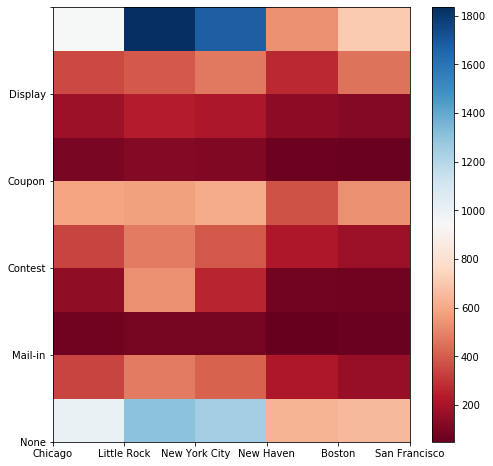

In [97]:
# Plot heatmap
f, ax = plt.subplots(figsize = (8, 8))
ax.set_xticklabels(cities)
ax.set_yticklabels(promotions)
plt.pcolor(df_pivot, cmap = 'RdBu')
plt.colorbar()
plt.show()

### The highest daily quantity occurs in Boston and San Fransico when the promotions are coupon, then display, then contest. This gives further insight to the client as to how to manage which types of promotions to send out to raise other location's performance to the level of their two best performing locations.

### I think one of the most beneficial things for a client trying to increase sales is a decision tree.

In [44]:
x_data = df3.drop('DailyQuantity', axis = 1)
y_data = df3['DailyQuantity']
dTree = tree.DecisionTreeClassifier()
dTree.fit(x_data, y_data)
dot_data = tree.export_graphviz(dTree, out_file = None)
graph = graphviz.Source(dot_data)
graph.render('iris')

'iris.pdf'

### The file is too large to fit well in the Jupyter Notebook, so it will be provided in a separate pdf.

### Although the decision tree produced by SciKit-Learn is optimal, a more useful decision tree can be produced manually. It would be better to hold things the client cannot vary constant, such as location, and keep those first in the tree. Then perhaps month followed by other parameters that are controllable by the client, such as discount and promotion type.